# Cirq Interoperability

Cirq is a quantum SDK for explicitly addressing physical qubits and scheduling gates. You can consider it analogous to a quantum assembly language. Qualtran provides interoperability with Cirq.

In [1]:
import cirq
from cirq.contrib.svg import SVGCircuit

from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature
from qualtran.drawing import show_bloq

## Using Cirq gates in Qualtran

 - `CirqGateAsBloq(gate)` lets you use any `cirq.Gate` as if it were a `qualtran.Bloq`.
 - `CompositeBloq.from_cirq_circuit(circuit)` converts a `cirq.Circuit` into an equivalent `qualtran.CompositeBloq`. For each gate in the circuit, we will try to translate it to a native bloq from the `qualtran.bloqs` standard library; otherwise we will wrap unknown operations with the `CirqGateAsBloq` adapter.

### `CirqGateAsBloq`

This wrapper uses the Cirq "calling convention" of one thru-register composted of a 1d array of qubits.

In [2]:
from qualtran.cirq_interop import CirqGateAsBloq

cgab = CirqGateAsBloq(cirq.QuantumFourierTransformGate(num_qubits=5))
print(cgab)
for reg in cgab.signature:
    print(' ', reg)

cirq.qft
  Register(name='q', dtype=QBit(), _shape=(5,), side=<Side.THRU: 3>)


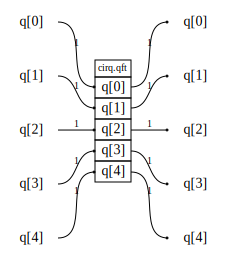

In [3]:
show_bloq(cgab)

### `CompositeBloq.from_cirq_circuit`

A Cirq circuit can be converted to a composite bloq by wrapping each operation with the `CirqGateAsBloq` wrapper. 

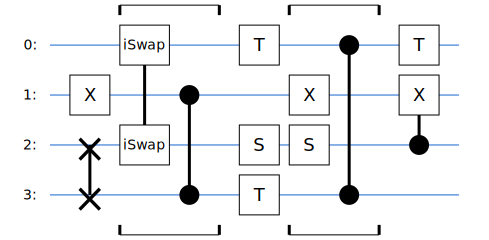

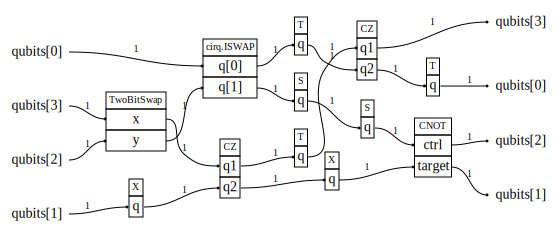

In [4]:
# Make a random cirq circuit
qubits = cirq.LineQubit.range(4)
circuit = cirq.testing.random_circuit(qubits, n_moments=5, op_density=1.0, random_state=52)

# Convert to CompositeBloq
cbloq = CompositeBloq.from_cirq_circuit(circuit)
display(SVGCircuit(circuit))
show_bloq(cbloq)

### Unitaries

Both containers support numerical contraction to a dense unitary matrix. Cirq contracts operations in order. Bloqs use `quimb` to find a good contraction ordering and perform the contraction. 

In [5]:
import numpy as np

bloq_unitary = cbloq.tensor_contract()
cirq_unitary = circuit.unitary(qubits)
np.testing.assert_allclose(cirq_unitary, bloq_unitary, atol=1e-8)

### [`CompositeBloq`](/reference/qualtran/CompositeBloq.md) back to `cirq.Circuit`

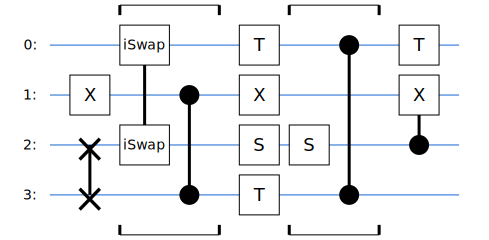

In [6]:
# Note: a 1d `shape` bloq register is actually two-dimensional in cirq conversion
# because of the implicit `bitsize` dimension (which must be explicit during cirq conversion).
# CirqGateAsBloq has registers of bitsize=1 and shape=(n,); hence the list transpose below.
circuit2 = cbloq.to_cirq_circuit(cirq_quregs={'qubits':[[q] for q in qubits]}, qubit_manager=cirq.ops.SimpleQubitManager())
SVGCircuit(circuit2)

In [7]:
# We lose the moment structure during the roundtrip.
circuit == circuit2

False

In [8]:
# But the left-aligned `circuit` is recovered.
cirq.Circuit(circuit.all_operations()) == circuit2

True

## Converting Bloqs to Cirq objects

 - `Bloq.as_cirq_op` is an overridable method to declare what cirq operation corresponds to a bloq.
 - `CompositeBloq.to_cirq_circuit` will export a CompositeBloq to a cirq.FrozenCircuit. Automatically takes care of qubit allocations / deallocations with sensible defaults for initial qubits.
 - `CompositeBloq.to_cirq_circuit_and_quregs` will export a CompositeBloq to a FrozenCircuit. Expects you to preallocate qubits for LEFT registers of the composite bloq and returns a dictionary mapping RIGHT registers of composite bloq to output qubit registers. 
 - `BloqAsCirqGate` provides a shim for using bloqs in cirq circuits automatically.

### `as_cirq_op` 

Bloqs can override `as_cirq_op` to optionally declare their corresponding Cirq operation. For example, the `SwapTwoBits` bloqs from the tutorial corresponds to `cirq.SWAP`.

The bloqs infrastructure will call `as_cirq_op` with keyword arguments mapping register names to `np.ndarray`s of `cirq.Qid` whose shape is `reg.shape + (reg.bitsize,)`. The type alias `CirqQuregT` is provided for convenience.

The method must return both the Cirq operation as well as a mapping from right register names to arrays of output `cirq.Qid`. This is to permit the use of qubit allocation facilities in `cirq`.

In [9]:
import attrs
from typing import *

from qualtran.cirq_interop import CirqQuregT

@attrs.frozen
class SwapTwoBits(Bloq):
    @property
    def signature(self):
        return Signature.build(x=1, y=1)
    
    def as_cirq_op(
            self, qubit_manager, x: CirqQuregT, y: CirqQuregT
    ) -> Tuple[cirq.Operation, Dict[str, CirqQuregT]]:
        x, = x  # each is an array of length one
        y, = y
        op = cirq.SWAP(x, y)
        out_quregs = {'x': [x], 'y': [y]}
        return op, out_quregs

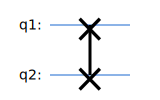

In [10]:
circuit, out_quregs = SwapTwoBits().as_composite_bloq()\
    .to_cirq_circuit_and_quregs(x=[cirq.NamedQubit('q1')], y=[cirq.NamedQubit('q2')])
SVGCircuit(circuit)

### `CompositeBloq.to_cirq_circuit` and `CompositeBloq.to_cirq_circuit_and_quregs`

A composite bloq can be turned into a circuit composed of the result of `as_cirq_op` for each of the subbloqs via `CompositeBloq.to_cirq_circuit`. 

A bloq's [`Signature`](/reference/qualtran/Signature.md) can be passed to a helper method `get_named_qubits` to instantiate Cirq qubits in the correct form for input to `CompositeBloq.to_cirq_circuit_and_quregs`. Users can also directly call `CompositeBloq.to_cirq_circuit()` which allocates the named qubits for you. 

In [11]:
from qualtran._infra.gate_with_registers import get_named_qubits

get_named_qubits(SwapTwoBits().signature.lefts())

{'x': array([cirq.NamedQubit('x')], dtype=object),
 'y': array([cirq.NamedQubit('y')], dtype=object)}

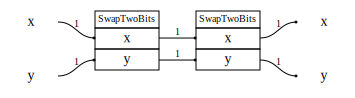

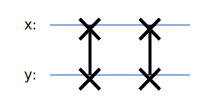

In [12]:
# Build a simple composite bloq
bb = BloqBuilder()
x = bb.add_register('x', 1)
y = bb.add_register('y', 1)
x, y = bb.add(SwapTwoBits(), x=x, y=y)
x, y = bb.add(SwapTwoBits(), x=x, y=y)
cbloq = bb.finalize(x=x, y=y)

# Turn it into a cirq circuit
circuit = cbloq.to_cirq_circuit()

# Observe
show_bloq(cbloq)
display(SVGCircuit(circuit))

### `BloqAsCirqGate`

The default behavior of `as_cirq_op` will shim the bloq into this object which lets you use a bloq in cirq circuits.

Below, we reproduce the multi-bit swap from the tutorial. This time, we do not implement `as_cirq_op` ourselves. This is appropriate if there isn't an equivalent gate in Cirq, which is likely the case for high-level bloqs.

In [13]:
from qualtran.cirq_interop import BloqAsCirqGate, cirq_optree_to_cbloq

@attrs.frozen
class Swap(Bloq):
    n: int

    @property
    def signature(self):
        return Signature.build(x=self.n, y=self.n)

    def build_composite_bloq(
            self, bb: 'BloqBuilder', *, x: 'SoquetT', y: 'SoquetT'
    ) -> Dict[str, 'SoquetT']:
        xs = bb.split(x)
        ys = bb.split(y)
        for i in range(self.n):
            xs[i], ys[i] = bb.add(SwapTwoBits(), x=xs[i], y=ys[i])
        return {'x': bb.join(xs), 'y': bb.join(ys)}

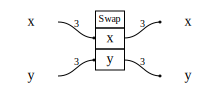

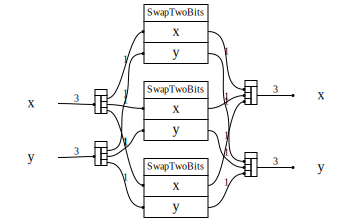

In [14]:
swap = Swap(n=3)
show_bloq(swap)
show_bloq(swap.decompose_bloq())

Instead, we get a `BloqAsCirqGate` by default.

In [15]:
circuit = swap.as_composite_bloq().to_cirq_circuit(
    cirq_quregs= {'x':cirq.LineQubit.range(3), 'y':cirq.LineQubit.range(100,103)}
)
(op,) = circuit.all_operations()
op

BloqAsCirqGate(Swap)(cirq.LineQubit(0), cirq.LineQubit(1), cirq.LineQubit(2), cirq.LineQubit(100), cirq.LineQubit(101), cirq.LineQubit(102))

This wrapper can delegate `cirq.decompose_once` calls to the bloq's decomposition. If the subbloqs in the decomposition have native `as_cirq_op` operations, then we successfully have a standard Cirq circuit.

In [16]:
swap_decomp_circuit = cirq.Circuit(cirq.decompose_once(op))
print(repr(swap_decomp_circuit))

cirq.Circuit([
    cirq.Moment(
        cirq.SWAP(cirq.LineQubit(0), cirq.LineQubit(100)),
        cirq.SWAP(cirq.LineQubit(1), cirq.LineQubit(101)),
        cirq.SWAP(cirq.LineQubit(2), cirq.LineQubit(102)),
    ),
])


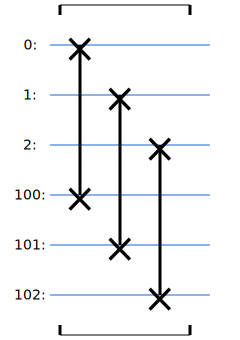

In [17]:
SVGCircuit(swap_decomp_circuit)

### Allocation and de-allocation

Cirq conversion can allocate and deallocate qubits with the help of qubit allocation tools in `cirq`. As an example, we look at the `MultiAnd` bloq. Behind the scenes, this uses the default `BloqAsCirqGate` shim which will allocate the target and junk right-only registers automatically.

In [18]:
from qualtran.bloqs.mcmt import MultiAnd

multi_and = MultiAnd(cvs=(1, 1, 1, 1))

Our input Cirq qubit registers include just the control qubits.

In [19]:
cirq_quregs = get_named_qubits(multi_and.signature.lefts())
cirq_quregs

{'ctrl': array([[cirq.NamedQubit('ctrl[0]')],
        [cirq.NamedQubit('ctrl[1]')],
        [cirq.NamedQubit('ctrl[2]')],
        [cirq.NamedQubit('ctrl[3]')]], dtype=object)}

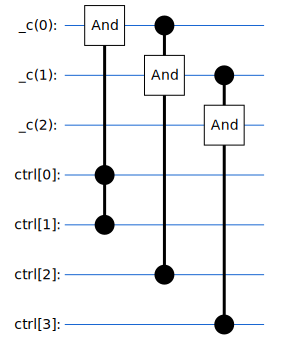

In [20]:
multi_and_circuit, out_quregs = multi_and.decompose_bloq().to_cirq_circuit_and_quregs(**cirq_quregs)
SVGCircuit(multi_and_circuit)

The second return value of `as_cirq_op` and `to_cirq_circuit_and_quregs` is the output cirq qubit registers that we can use to identify allocated qubits.

In [21]:
# Note the new precense of `junk` and `target` entries.
out_quregs

{'ctrl': array([[cirq.NamedQubit('ctrl[0]')],
        [cirq.NamedQubit('ctrl[1]')],
        [cirq.NamedQubit('ctrl[2]')],
        [cirq.NamedQubit('ctrl[3]')]], dtype=object),
 'junk': array([[cirq.ops.CleanQubit(0)],
        [cirq.ops.CleanQubit(1)]], dtype=object),
 'target': array([cirq.ops.CleanQubit(2)], dtype=object)}

## Test `Bloqs -> Cirq -> Bloqs` roundtrip using `ModExp`

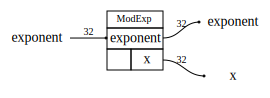

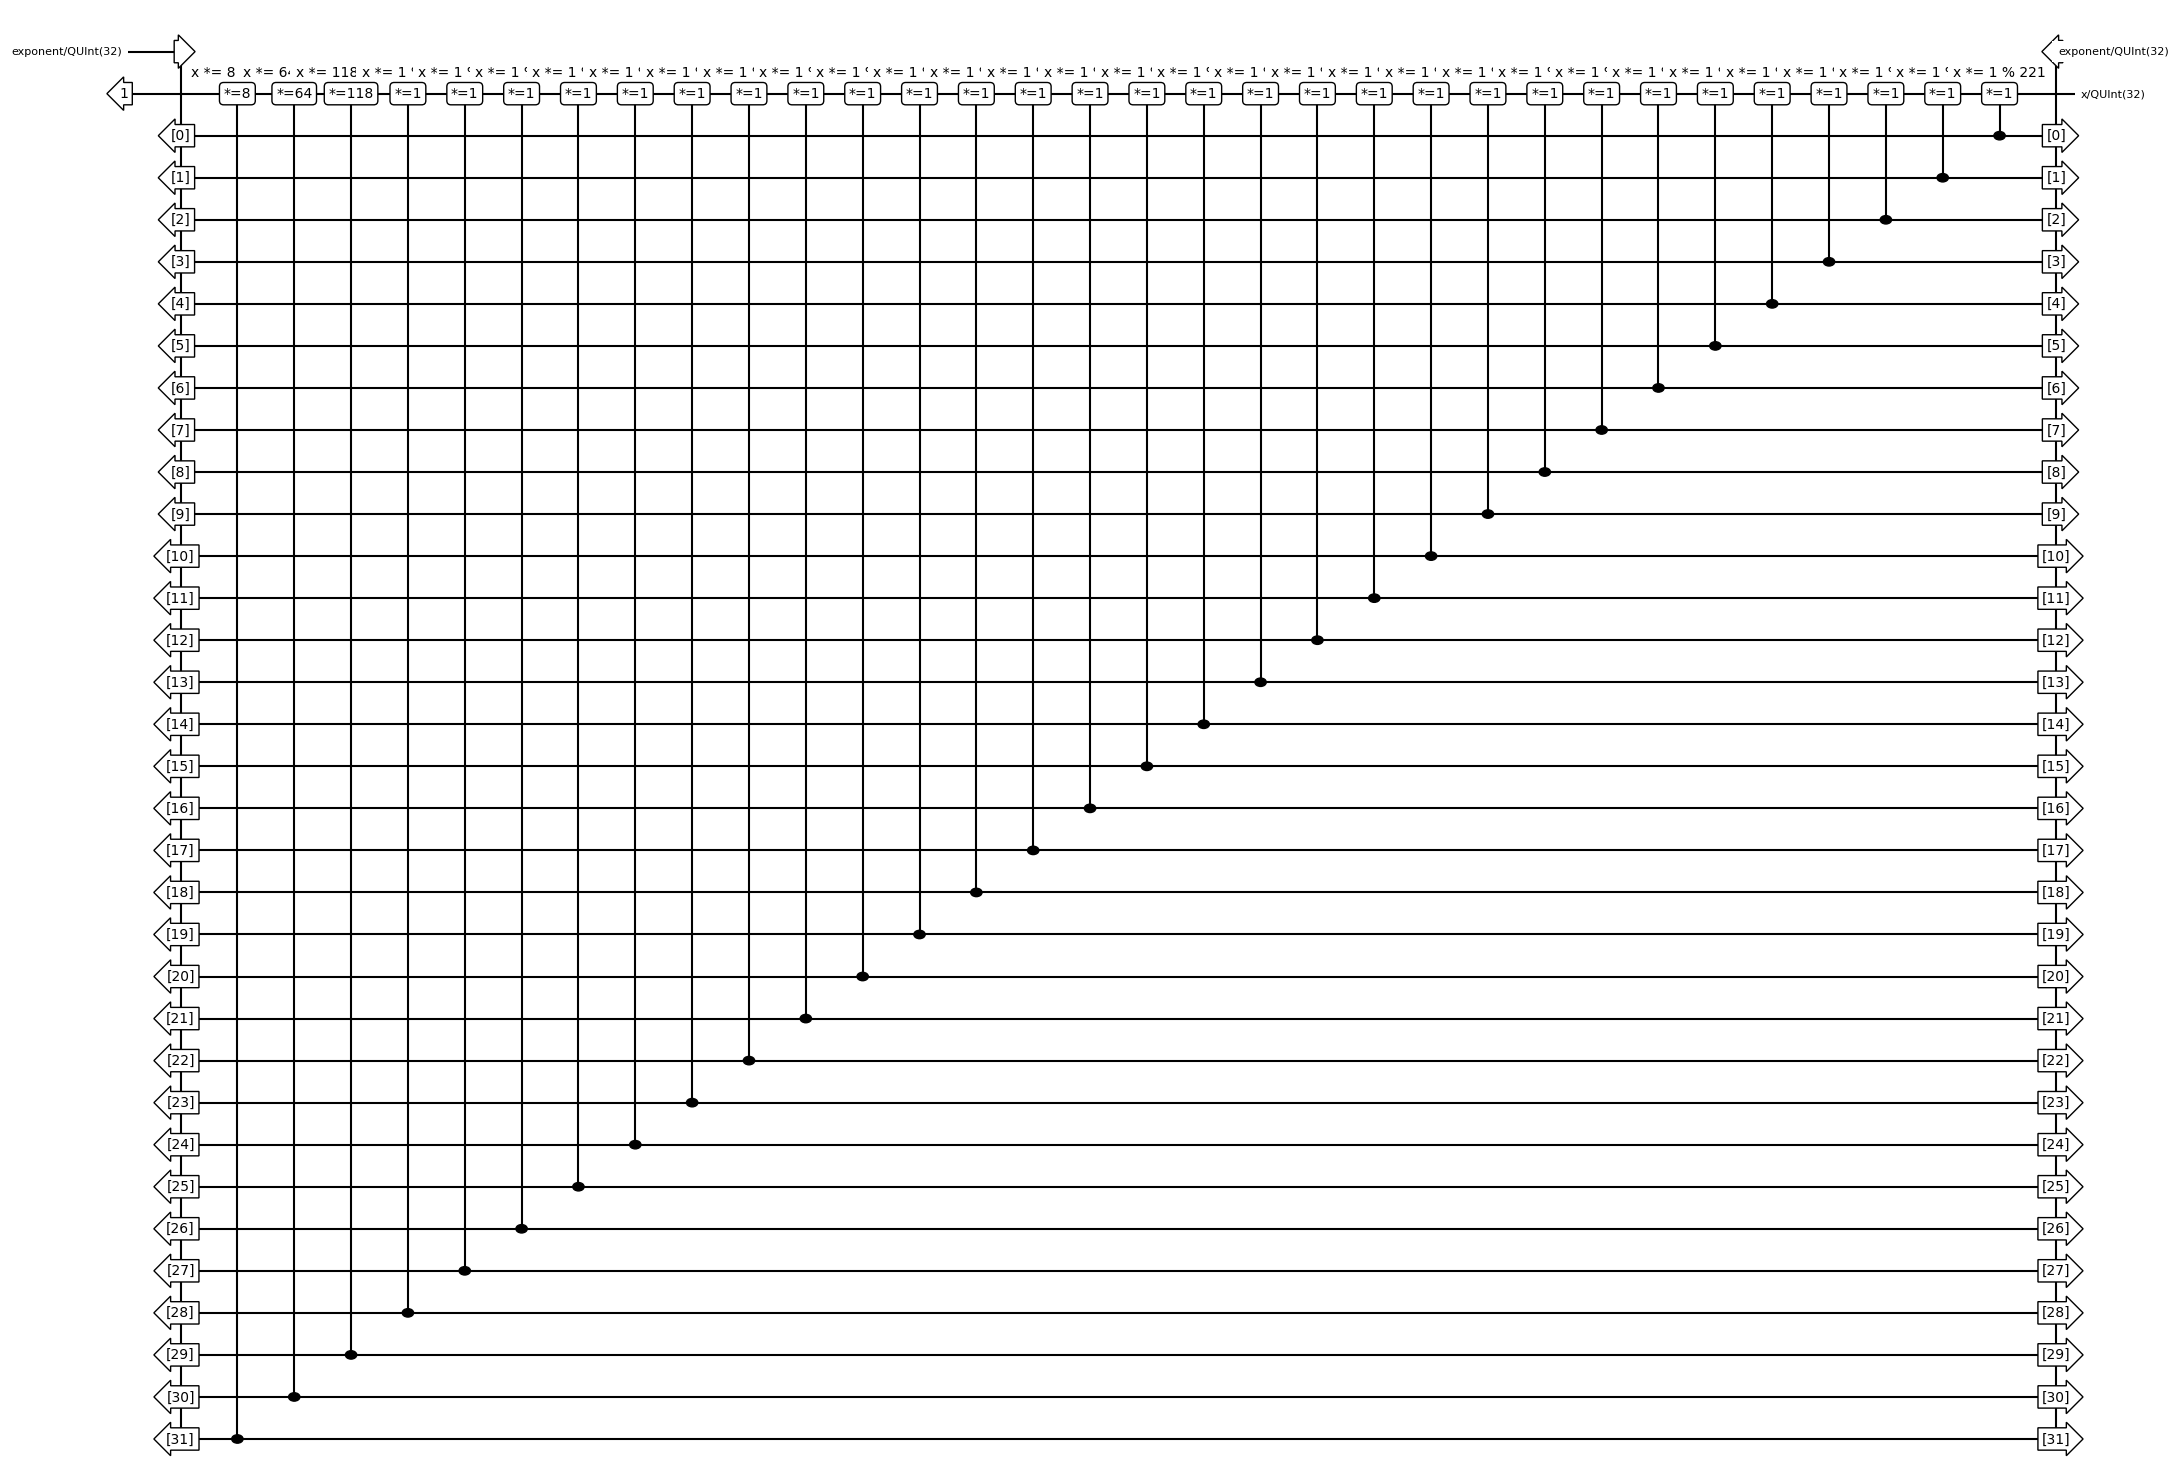

In [22]:
from qualtran.bloqs.cryptography.rsa import ModExp
from qualtran.drawing import show_bloq
from qualtran.drawing import get_musical_score_data, draw_musical_score
N = 13*17
n = int(np.ceil(np.log2(N)))
g = 8
mod_exp = ModExp(base=g, mod=N, exp_bitsize=32, x_bitsize=32)
show_bloq(mod_exp)
cbloq = mod_exp.decompose_bloq()
fig, ax = draw_musical_score(get_musical_score_data(cbloq))
fig.set_size_inches(24, 15)

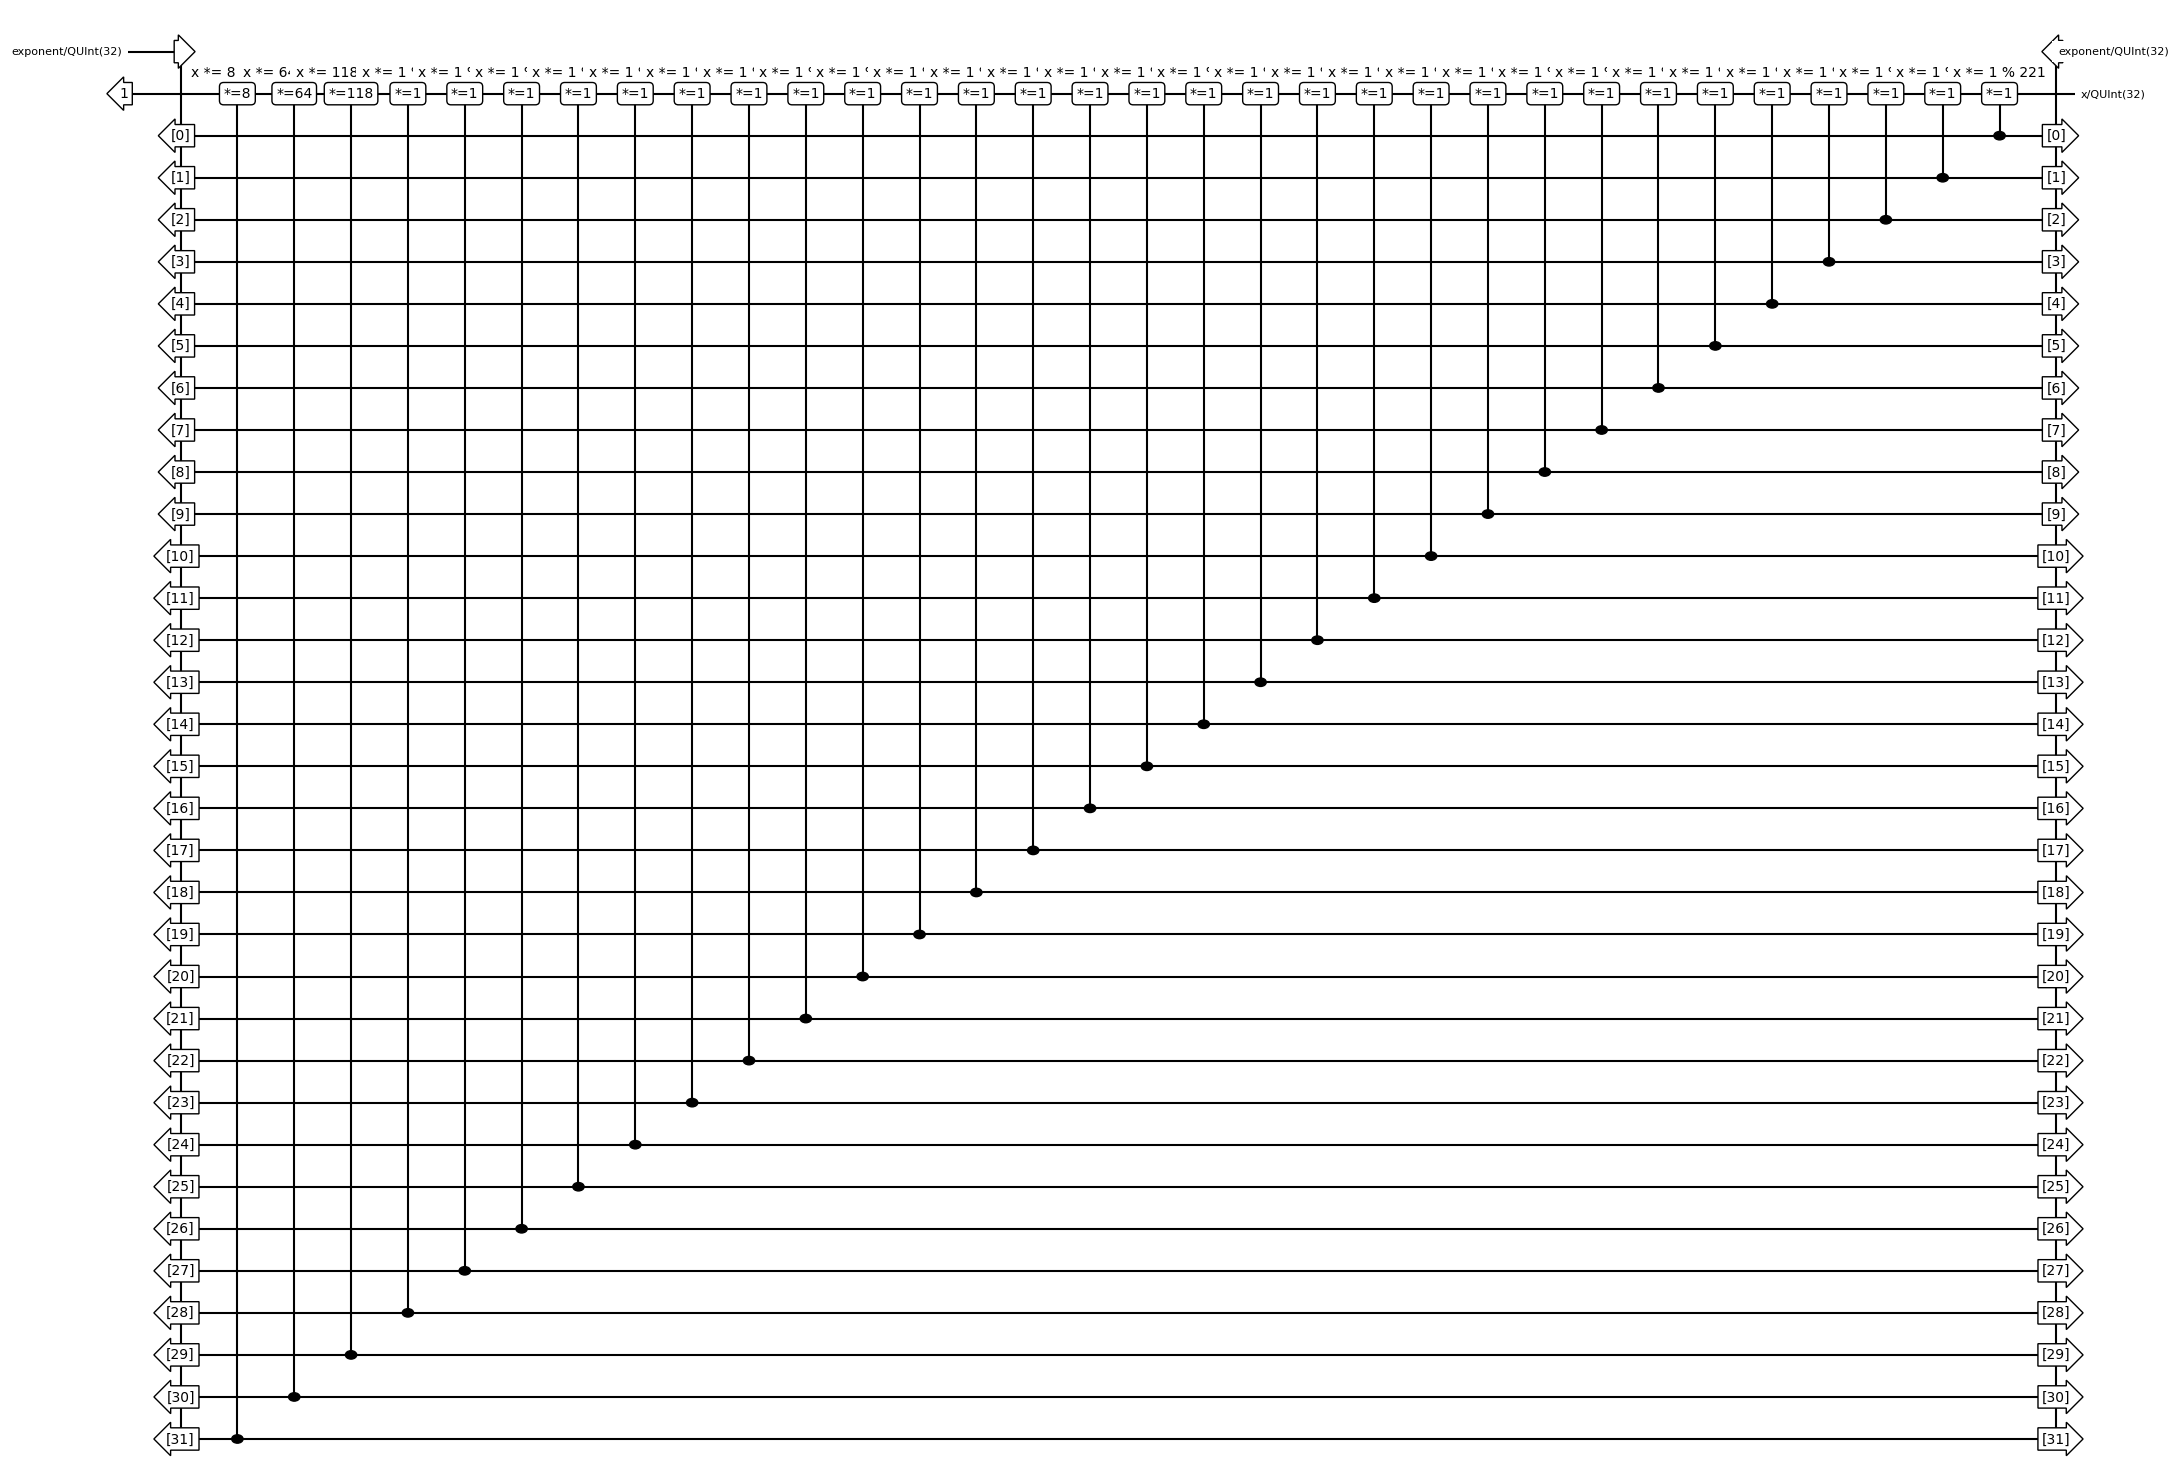

In [23]:
in_quregs = {'exponent': np.array(cirq.LineQubit.range(32))}

op, out_quregs = BloqAsCirqGate.bloq_on(mod_exp, cirq_quregs=in_quregs, qubit_manager=cirq.ops.SimpleQubitManager())

# 1. Decompose using cirq.decompose_once(op) and then convert back into a CompositeBloq.
decomposed_circuit = cirq.Circuit(cirq.decompose_once(op))
cbloq = cirq_optree_to_cbloq(decomposed_circuit, signature=mod_exp.signature, in_quregs=in_quregs, out_quregs=out_quregs)
fig, ax = draw_musical_score(get_musical_score_data(cbloq))
fig.set_size_inches(24, 15)

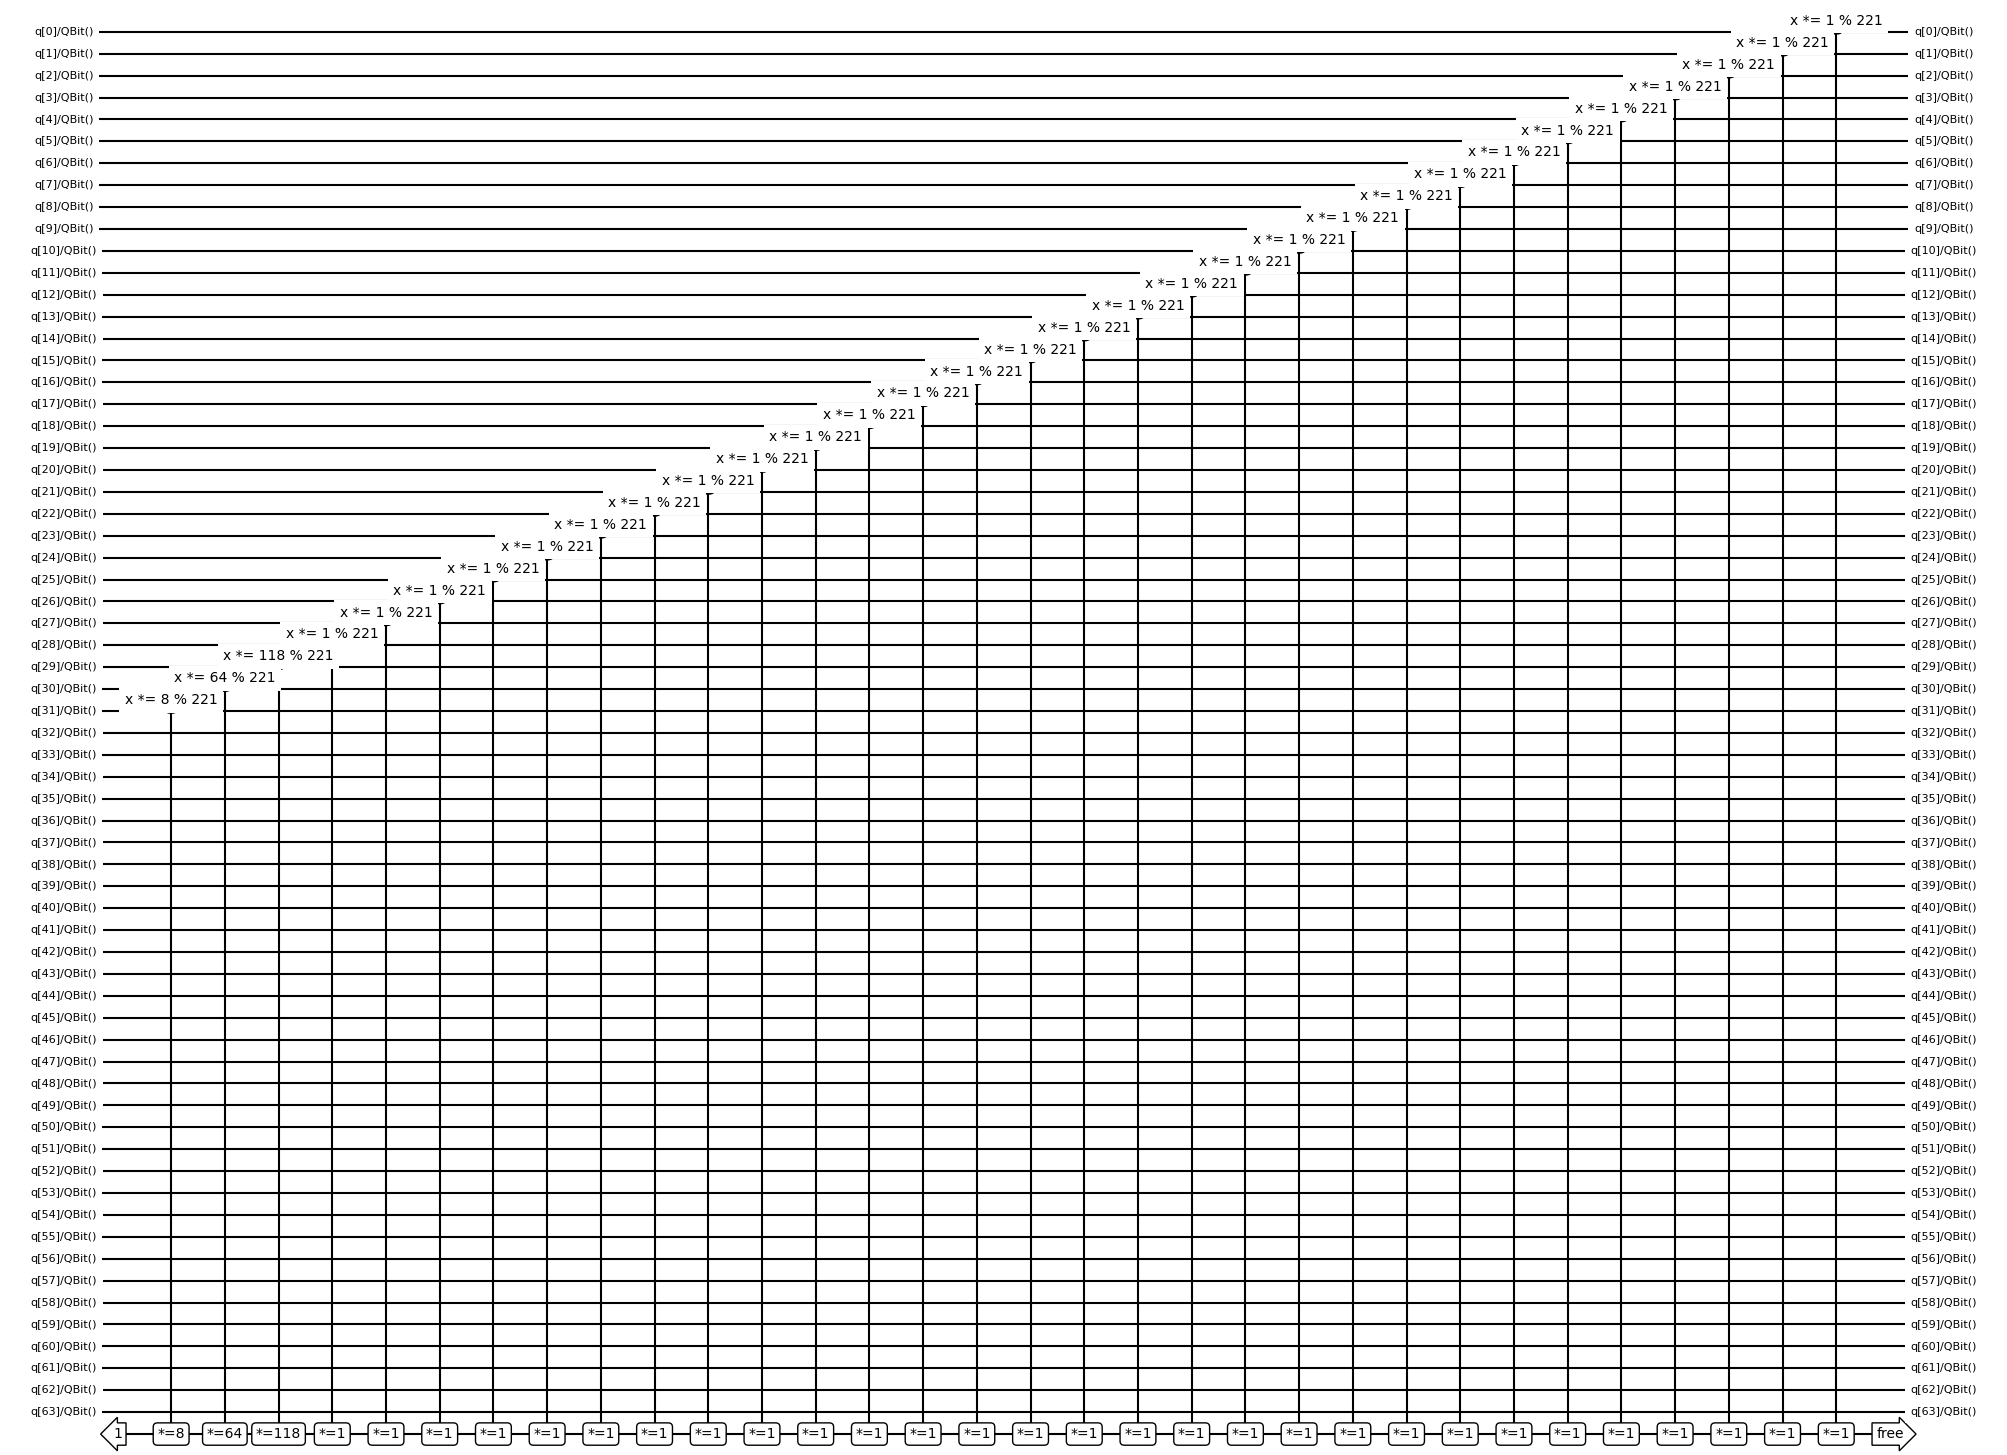

In [24]:
# 2. Ensure that Bloq -> BloqAsCirqGate -> CirqGateAsBloq.decompose_bloq() roundtrip works as expected.
# This makes sure no information is lost when converting from Bloqs -> Cirq -> Bloqs.
bloq = CirqGateAsBloq(BloqAsCirqGate(mod_exp))
cbloq = CirqGateAsBloq(op.gate).decompose_bloq()
fig, ax = draw_musical_score(get_musical_score_data(cbloq))
fig.set_size_inches(24, 15)